# **ANÁLISIS DE RESULTADOS DE PREDICCIÓN**

Analizaremos os resultados obtenidos




# Setup, imports y utilidades

In [ ]:
# =========================
#  Setup & Utilities
# =========================
import re
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patheffects as pe
from matplotlib.lines import Line2D


from pathlib import Path
from google.colab import drive #import data from my drive


import warnings
warnings.filterwarnings('ignore')


In [ ]:
pd.set_option("display.max_colwidth", 200)

# Estética global
sns.set_theme(style="whitegrid", context="talk", palette="deep")

hue_order_full = ["Positive", "Negative", "Neutral", "Indeterminate"]

palette_sent = {
    "Positive":      "#2C7BE5",  # harmonious blue
    "Negative":      "#E76F51",  # medium muted red
    "Neutral":       "#9AA0A6",  # gray
    "Indeterminate": "#F4D35E",  # amber (recommended)
}

def _slugify(text: str) -> str:
    """Safe filename slug: lowercase, alphanumerics and underscores only."""
    text = text.strip().lower()
    text = re.sub(r"[^\w\s-]", "", text)
    text = re.sub(r"[\s-]+", "_", text)
    return text

def save_figure(fig, name: str, subdir: str = "figures/", dpi: int = 300, ext: str = "pdf"):
    """
    Save a Matplotlib figure as PNG with consistent, publication-ready settings.
    - fig: a Matplotlib Figure (e.g., returned by plt.figure() or ax.figure).
    - name: base filename (will be slugified, '.png' appended automatically).
    - subdir: output directory; created if missing.
    - dpi: export resolution.
    """
    # Normaliza y valida extensión
    ext = (ext or "pdf").strip(".").lower()
    if ext not in {"pdf", "png"}:
        raise ValueError("Parameter 'ext' must be 'pdf' or 'png'.")

    out_dir = Path(subdir)
    out_dir.mkdir(parents=True, exist_ok=True)

    fname = out_dir / f"{_slugify(name)}.{ext}"
    fig.savefig(
        fname,
        dpi=dpi,
        bbox_inches="tight",
        facecolor="white",
        transparent=False
    )
    print(f"[saved] {fname}")

#Carga de datos

In [ ]:
drive.mount('/drive')
path = '/drive/My Drive/Colab Notebooks/infotracer/RESEARCH/'
print(f'Ruta del proyecto: {path}')

Mounted at /drive
Ruta del proyecto: /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/


## Ground-truth

In [ ]:
df_unified = pd.read_csv(path + 'results/omd_sent_groundtruth_mex24.csv')
df_unified

,platform,text,A0001,A0002,A0003,sentiment_label
0,Facebook,"La ""gira de la transición"" 🛩️🇲🇽 llevará a AMLO y Claudia Sheinbaum 🙋🏻‍♀️ a visitar varias entidades a partir de este fin de semana 👇",NEU,NEU,NEU,NEU
1,Facebook,"Nuestra propuesta para hoy es esta bellísima cartera en un delicado tono palo de rosa 😍 con tiro de cadena dorada, que le da ese toque sutil y elegante que estás buscando, tamaño mediano pero bast...",POS,POS,POS,POS
2,Facebook,"hoy les traigo el debate del Presidente vs Jorge Ramos, Claudia sheinbaum responde a pregunta sobre las conferencias de Xochitl y Noroña como representante d...",NEU,NEU,NEU,NEU
3,Facebook,Que buen discurso \n\n#AndresManuelLopezObrador #ClaudiaSheinbaumPresidenta2024 #Sheinbaum #AMLOELMEJORPRESIDENTE #AMLOLujoDePresidente #MORENA2024 #AMLOVER #AMLOPRESIDENTE #SomosMorena #SoyMorena...,POS,POS,POS,POS
4,Facebook,. 🚴✖️🔴 en Washington 🇺🇸 lunes 5 de febrero Llegando a mi reunión con el Consejo Editorial del Washington Post. #XochitlVa #XochitlGalvez #FuerzaRosa #EstamosListosX,NEU,NEU,NEU,NEU
...,...,...,...,...,...,...
1349,Youtube,"""Se han pagado pensiones de enero a junio"", anuncian en la Secretaría de Bienestar __ ¡Únete a nuestra comunidad en TikTok y sé parte de la conversación! 💬🚀 ¡Haz clic en seguir y acompáñanos en es...",NEU,POS,NEU,NEU
1350,Youtube,"🔥 El PEJE HASTA el CUELLO: ¡ESTE VIDEAZO de LORET HIZO TEMBLAR PALACIO NACIONAL! ¡MÍRALO AHORA! __ Ha tomado decisiones que le han costado a México crecimiento económico, empleos, huida de capital...",NEG,NEG,NEG,NEG
1351,Youtube,"AGENDA LLENA 📅. CLAUDIA SHEINBAUM anuncia actividades del 1 de OCTUBRE sobre la toma de protesta 🤚 __ La virtual presidenta electa de México 2024-2030, Claudia Sheinbaum, anunció sus actividades d...",NEU,NEU,POS,NEU
1352,Youtube,"🔥 INAI PONE en JAQUE al PEJE: ¡LORET SUELTA ENTREVISTA EXCLUSIVA! ¡Se le ACABÓ la FIESTA al TARTUFO! __ El Instituto Nacional de Transparencia y Protección de Datos Personales (INAI), inició un an...",NEG,NEG,NEG,NEG


## Pre-trained models

In [ ]:
df_results_dl = pd.read_csv(path + 'results/omd_sent_PreTrained_pred_mex24.csv')
df_results_dl

,platform,text,sentiment_label,sentiment_bert_multilingual,sentiment_beto,sentiment_pysentimiento,sentiment_roberta
0,Facebook,"La ""gira de la transición"" 🛩️🇲🇽 llevará a AMLO y Claudia Sheinbaum 🙋🏻‍♀️ a visitar varias entidades a partir de este fin de semana 👇",NEU,POS,POS,NEU,NEU
1,Facebook,"Nuestra propuesta para hoy es esta bellísima cartera en un delicado tono palo de rosa 😍 con tiro de cadena dorada, que le da ese toque sutil y elegante que estás buscando, tamaño mediano pero bast...",POS,POS,POS,POS,POS
2,Facebook,"hoy les traigo el debate del Presidente vs Jorge Ramos, Claudia sheinbaum responde a pregunta sobre las conferencias de Xochitl y Noroña como representante d...",NEU,NEG,NEU,NEU,NEU
3,Facebook,Que buen discurso \n\n#AndresManuelLopezObrador #ClaudiaSheinbaumPresidenta2024 #Sheinbaum #AMLOELMEJORPRESIDENTE #AMLOLujoDePresidente #MORENA2024 #AMLOVER #AMLOPRESIDENTE #SomosMorena #SoyMorena...,POS,POS,POS,NEU,NEU
4,Facebook,. 🚴✖️🔴 en Washington 🇺🇸 lunes 5 de febrero Llegando a mi reunión con el Consejo Editorial del Washington Post. #XochitlVa #XochitlGalvez #FuerzaRosa #EstamosListosX,NEU,NEG,NEU,NEU,NEU
...,...,...,...,...,...,...,...
1349,Youtube,"""Se han pagado pensiones de enero a junio"", anuncian en la Secretaría de Bienestar __ ¡Únete a nuestra comunidad en TikTok y sé parte de la conversación! 💬🚀 ¡Haz clic en seguir y acompáñanos en es...",NEU,POS,POS,NEU,NEU
1350,Youtube,"🔥 El PEJE HASTA el CUELLO: ¡ESTE VIDEAZO de LORET HIZO TEMBLAR PALACIO NACIONAL! ¡MÍRALO AHORA! __ Ha tomado decisiones que le han costado a México crecimiento económico, empleos, huida de capital...",NEG,NEG,NEG,NEG,NEU
1351,Youtube,"AGENDA LLENA 📅. CLAUDIA SHEINBAUM anuncia actividades del 1 de OCTUBRE sobre la toma de protesta 🤚 __ La virtual presidenta electa de México 2024-2030, Claudia Sheinbaum, anunció sus actividades d...",NEU,NEG,NEU,NEU,NEU
1352,Youtube,"🔥 INAI PONE en JAQUE al PEJE: ¡LORET SUELTA ENTREVISTA EXCLUSIVA! ¡Se le ACABÓ la FIESTA al TARTUFO! __ El Instituto Nacional de Transparencia y Protección de Datos Personales (INAI), inició un an...",NEG,NEG,NEU,NEG,NEU


## LLMs

In [ ]:
df_results_LLMs = pd.read_csv(path + 'results/omd_sent_LLM_pred_mex24.csv')
df_results_LLMs

,platform,text,sentiment_label,zero_gpt-3.5-turbo_sentiment,zero_gpt-4o-mini_sentiment,zero_gpt_o1-mini_sentiment,zero_llama3_sentiment,zero_llama3.1_sentiment,few_gpt-3.5-turbo_sentiment,few_gpt-4o-mini_sentiment,few_gpt_o1-mini_sentiment,few_llama3_sentiment,few_llama3.1_sentiment
0,Facebook,"La ""gira de la transición"" 🛩️🇲🇽 llevará a AMLO y Claudia Sheinbaum 🙋🏻‍♀️ a visitar varias entidades a partir de este fin de semana 👇",NEU,NEU,NEU,NEU,NEU,NEU,POS,NEU,NEU,NEU,NEU
1,Facebook,"Nuestra propuesta para hoy es esta bellísima cartera en un delicado tono palo de rosa 😍 con tiro de cadena dorada, que le da ese toque sutil y elegante que estás buscando, tamaño mediano pero bast...",POS,POS,POS,POS,POS,POS,POS,POS,POS,POS,POS
2,Facebook,"hoy les traigo el debate del Presidente vs Jorge Ramos, Claudia sheinbaum responde a pregunta sobre las conferencias de Xochitl y Noroña como representante d...",NEU,NEU,NEU,NEU,NEU,NEG,NEU,NEU,NEU,NEU,NEU
3,Facebook,Que buen discurso \n\n#AndresManuelLopezObrador #ClaudiaSheinbaumPresidenta2024 #Sheinbaum #AMLOELMEJORPRESIDENTE #AMLOLujoDePresidente #MORENA2024 #AMLOVER #AMLOPRESIDENTE #SomosMorena #SoyMorena...,POS,POS,POS,POS,POS,POS,POS,POS,POS,POS,POS
4,Facebook,. 🚴✖️🔴 en Washington 🇺🇸 lunes 5 de febrero Llegando a mi reunión con el Consejo Editorial del Washington Post. #XochitlVa #XochitlGalvez #FuerzaRosa #EstamosListosX,NEU,POS,POS,NEU,POS,NEU,POS,NEU,POS,POS,NEU
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349,Youtube,"""Se han pagado pensiones de enero a junio"", anuncian en la Secretaría de Bienestar __ ¡Únete a nuestra comunidad en TikTok y sé parte de la conversación! 💬🚀 ¡Haz clic en seguir y acompáñanos en es...",NEU,POS,POS,POS,POS,POS,POS,POS,POS,POS,NEU
1350,Youtube,"🔥 El PEJE HASTA el CUELLO: ¡ESTE VIDEAZO de LORET HIZO TEMBLAR PALACIO NACIONAL! ¡MÍRALO AHORA! __ Ha tomado decisiones que le han costado a México crecimiento económico, empleos, huida de capital...",NEG,NEG,NEG,NEG,POS,NEG,NEG,NEG,NEG,NEG,NEG
1351,Youtube,"AGENDA LLENA 📅. CLAUDIA SHEINBAUM anuncia actividades del 1 de OCTUBRE sobre la toma de protesta 🤚 __ La virtual presidenta electa de México 2024-2030, Claudia Sheinbaum, anunció sus actividades d...",NEU,POS,POS,NEU,POS,NEG,NEU,NEU,NEU,NEU,NEU
1352,Youtube,"🔥 INAI PONE en JAQUE al PEJE: ¡LORET SUELTA ENTREVISTA EXCLUSIVA! ¡Se le ACABÓ la FIESTA al TARTUFO! __ El Instituto Nacional de Transparencia y Protección de Datos Personales (INAI), inició un an...",NEG,NEG,NEG,NEG,POS,NEG,NEU,NEG,NEG,NEG,NEG


# Preprocesamiento

## Supuestos y aserciones

In [ ]:
# =========================
# 1) Preconditions
# =========================


required_unified = {'platform','text','sentiment_label'}
assert required_unified.issubset(df_unified.columns), f"df_unified necesita columnas {required_unified}"

assert 'text' in df_results_dl.columns, "df_results_dl debe incluir 'text'"
assert 'text' in df_results_LLMs.columns, "df_results_LLMs debe incluir 'text'"

print("df_unified:", df_unified.shape, " | df_results_dl:", df_results_dl.shape, " | df_results_LLMs:", df_results_LLMs.shape)


df_unified: (1354, 6)  | df_results_dl: (1354, 7)  | df_results_LLMs: (1354, 13)


## Mapas y Etiquetas globales

In [ ]:
# =========================
# 2) Label maps (globales)
# =========================
# numérico → texto
label_map = {0: "NEG", 1: "POS", 2: "NEU"}

# textual (multilingüe + variantes)
label_map_textual = {
    # Inglés
    "negative": "NEG", "neg": "NEG",
    "positive": "POS", "pos": "POS",
    "neutral":  "NEU", "neu": "NEU",
    "negative.": "NEG", "positive.": "POS", "neutral.": "NEU",

    # Español/Portugués (+género/plural)
    "negativo": "NEG", "negativa": "NEG", "negativos": "NEG", "negativas": "NEG",
    "positivo": "POS", "positiva": "POS", "positivos": "POS", "positivas": "POS",
    "neutro": "NEU", "neutra": "NEU", "neutros": "NEU", "neutras": "NEU",
    "neutralidad": "NEU",

    # Typos frecuentes
    "negtive": "NEG", "negetive": "NEG", "negitive": "NEG", "negaive": "NEG", "negaitive": "NEG",
    "negativ": "NEG",
    "positve": "POS", "postive": "POS", "positiv": "POS",
    "neutal": "NEU", "netural": "NEU", "nuetral": "NEU",

    # Números como string
    "0": "NEG", "1": "POS", "2": "NEU",

    # Estándares ya normalizados
    "neg": "NEG", "pos": "POS", "neu": "NEU",

    # Casos especiales a indeterminado
    "cannot_predict": "INDETERMINATE"
}
VALID = {"NEG","POS","NEU"}

label_display = {
    "POS": "Positive",
    "NEG": "Negative",
    "NEU": "Neutral",
    "INDETERMINATE": "Indeterminate"
}


In [ ]:
# =========================
# 3) DL integration & normalization
# =========================

# Candidatas DL
dl_candidates = [
    'sentiment_bert_multilingual',
    'sentiment_beto',
    'sentiment_pysentimiento',
    'sentiment_roberta'
]
dl_cols = [c for c in dl_candidates if c in df_results_dl.columns]

#def stars_to_label(x):
#    """
#    Mapea:
#      - '1 star', '2 stars', '★★', '⭐', 'rating 3/5' → NEG/NEU/POS
#      - NaN o formato desconocido → INDETERMINATE
#    """
#    if pd.isna(x):
#        return "INDETERMINATE"
#    s = str(x).strip().lower()
#    # Cuenta estrellas unicode
#    star_count = s.count("★") + s.count("⭐")
#    if star_count == 0:
#        m = re.search(r'([1-5])', s)
#        star_count = int(m.group(1)) if m else None
#    if star_count is None:
#        return "INDETERMINATE"
#    if star_count in (1,2): return "NEG"
#    if star_count == 3:     return "NEU"
#    if star_count in (4,5): return "POS"
#    return "INDETERMINATE"

# Aplica a BERT multilingual si existe (y guarda copia raw)
#if 'sentiment_bert_multilingual' in dl_cols:
#    if 'sentiment_bert_multilingual_raw' not in df_results_dl.columns:
#        df_results_dl['sentiment_bert_multilingual_raw'] = df_results_dl['sentiment_bert_multilingual']
#    df_results_dl['sentiment_bert_multilingual'] = df_results_dl['sentiment_bert_multilingual'].apply(stars_to_label)

# Blancos → INDETERMINATE en el resto de columnas DL clásicas
for col in [c for c in ['sentiment_bert_multilingual', 'sentiment_beto','sentiment_pysentimiento','sentiment_roberta'] if c in dl_cols]:
    mask_blank = df_results_dl[col].isna() | df_results_dl[col].astype(str).str.strip().eq('')
    df_results_dl.loc[mask_blank, col] = "INDETERMINATE"

def normalize_series_to_labels(s: pd.Series) -> pd.Series:
    s_str = s.astype(str).str.strip()
    # Primero mapeo numérico
    mapped = s.map(label_map)
    # Luego textual (lower)
    mapped = mapped.fillna(s_str.str.lower().map(label_map_textual))
    # Quitar punto final y re-mapear textual
    mapped = mapped.fillna(s_str.replace(r'[.]$','', regex=True).str.lower().map(label_map_textual))
    # Mantener si ya es NEG/POS/NEU; resto → INDETERMINATE
    mapped = mapped.where(mapped.isin(VALID), mapped)
    mapped = mapped.where(mapped.isin(VALID), "INDETERMINATE")
    return mapped

# Normaliza todas las columnas DL a NEG/POS/NEU/INDETERMINATE
for col in dl_cols:
    df_results_dl[col] = normalize_series_to_labels(df_results_dl[col])

print("[DL] Columnas integradas y normalizadas:", dl_cols)


[DL] Columnas integradas y normalizadas: ['sentiment_bert_multilingual', 'sentiment_beto', 'sentiment_pysentimiento', 'sentiment_roberta']


In [ ]:
# =========================
# 4) LLM normalization safety pass
# =========================
# Con los resultados ya normalizados, esto simplemente re-confirma los rótulos.
# Incluye la conversión de 'CANNOT_PREDICT' → INDETERMINATE

expected_sent_cols = [
    'zero_gpt-3.5-turbo_sentiment',
    'zero_gpt-4o-mini_sentiment',
    'zero_gpt_o1-mini_sentiment',
    'zero_llama3_sentiment',
    'zero_llama3.1_sentiment',
    'few_gpt-3.5-turbo_sentiment',
    'few_gpt-4o-mini_sentiment',
    'few_gpt_o1-mini_sentiment',
    'few_llama3_sentiment',
    'few_llama3.1_sentiment',
]
llm_cols = [c for c in expected_sent_cols if c in df_results_LLMs.columns]

for col in llm_cols:
    df_results_LLMs[col] = normalize_series_to_labels(df_results_LLMs[col])

print("[LLMs] Columnas normalizadas (safety pass):", llm_cols)


[LLMs] Columnas normalizadas (safety pass): ['zero_gpt-3.5-turbo_sentiment', 'zero_gpt-4o-mini_sentiment', 'zero_gpt_o1-mini_sentiment', 'zero_llama3_sentiment', 'zero_llama3.1_sentiment', 'few_gpt-3.5-turbo_sentiment', 'few_gpt-4o-mini_sentiment', 'few_gpt_o1-mini_sentiment', 'few_llama3_sentiment', 'few_llama3.1_sentiment']


In [ ]:
# =========================
# 5) Ensamble de evaluación
# =========================
SENTS = ["POS","NEG","NEU"]
SENT_DISPLAY = {"POS":"Positive","NEG":"Negative","NEU":"Neutral"}

df_eval = (
    df_unified[['platform','text','sentiment_label']]
      .merge(df_results_dl[['text'] + dl_cols] if dl_cols else df_unified[['text']], on='text', how='left')
      .merge(df_results_LLMs[['text'] + llm_cols] if llm_cols else df_unified[['text']], on='text', how='left')
)

print("df_eval:", df_eval.shape)


df_eval: (1354, 17)


In [ ]:
df_eval

,platform,text,sentiment_label,sentiment_bert_multilingual,sentiment_beto,sentiment_pysentimiento,sentiment_roberta,zero_gpt-3.5-turbo_sentiment,zero_gpt-4o-mini_sentiment,zero_gpt_o1-mini_sentiment,zero_llama3_sentiment,zero_llama3.1_sentiment,few_gpt-3.5-turbo_sentiment,few_gpt-4o-mini_sentiment,few_gpt_o1-mini_sentiment,few_llama3_sentiment,few_llama3.1_sentiment
0,Facebook,"La ""gira de la transición"" 🛩️🇲🇽 llevará a AMLO y Claudia Sheinbaum 🙋🏻‍♀️ a visitar varias entidades a partir de este fin de semana 👇",NEU,POS,POS,NEU,NEU,NEU,NEU,NEU,NEU,NEU,POS,NEU,NEU,NEU,NEU
1,Facebook,"Nuestra propuesta para hoy es esta bellísima cartera en un delicado tono palo de rosa 😍 con tiro de cadena dorada, que le da ese toque sutil y elegante que estás buscando, tamaño mediano pero bast...",POS,POS,POS,POS,POS,POS,POS,POS,POS,POS,POS,POS,POS,POS,POS
2,Facebook,"hoy les traigo el debate del Presidente vs Jorge Ramos, Claudia sheinbaum responde a pregunta sobre las conferencias de Xochitl y Noroña como representante d...",NEU,NEG,NEU,NEU,NEU,NEU,NEU,NEU,NEU,NEG,NEU,NEU,NEU,NEU,NEU
3,Facebook,Que buen discurso \n\n#AndresManuelLopezObrador #ClaudiaSheinbaumPresidenta2024 #Sheinbaum #AMLOELMEJORPRESIDENTE #AMLOLujoDePresidente #MORENA2024 #AMLOVER #AMLOPRESIDENTE #SomosMorena #SoyMorena...,POS,POS,POS,NEU,NEU,POS,POS,POS,POS,POS,POS,POS,POS,POS,POS
4,Facebook,. 🚴✖️🔴 en Washington 🇺🇸 lunes 5 de febrero Llegando a mi reunión con el Consejo Editorial del Washington Post. #XochitlVa #XochitlGalvez #FuerzaRosa #EstamosListosX,NEU,NEG,NEU,NEU,NEU,POS,POS,NEU,POS,NEU,POS,NEU,POS,POS,NEU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349,Youtube,"""Se han pagado pensiones de enero a junio"", anuncian en la Secretaría de Bienestar __ ¡Únete a nuestra comunidad en TikTok y sé parte de la conversación! 💬🚀 ¡Haz clic en seguir y acompáñanos en es...",NEU,POS,POS,NEU,NEU,POS,POS,POS,POS,POS,POS,POS,POS,POS,NEU
1350,Youtube,"🔥 El PEJE HASTA el CUELLO: ¡ESTE VIDEAZO de LORET HIZO TEMBLAR PALACIO NACIONAL! ¡MÍRALO AHORA! __ Ha tomado decisiones que le han costado a México crecimiento económico, empleos, huida de capital...",NEG,NEG,NEG,NEG,NEU,NEG,NEG,NEG,POS,NEG,NEG,NEG,NEG,NEG,NEG
1351,Youtube,"AGENDA LLENA 📅. CLAUDIA SHEINBAUM anuncia actividades del 1 de OCTUBRE sobre la toma de protesta 🤚 __ La virtual presidenta electa de México 2024-2030, Claudia Sheinbaum, anunció sus actividades d...",NEU,NEG,NEU,NEU,NEU,POS,POS,NEU,POS,NEG,NEU,NEU,NEU,NEU,NEU
1352,Youtube,"🔥 INAI PONE en JAQUE al PEJE: ¡LORET SUELTA ENTREVISTA EXCLUSIVA! ¡Se le ACABÓ la FIESTA al TARTUFO! __ El Instituto Nacional de Transparencia y Protección de Datos Personales (INAI), inició un an...",NEG,NEG,NEU,NEG,NEU,NEG,NEG,NEG,POS,NEG,NEU,NEG,NEG,NEG,NEG


# Metricas

In [ ]:
# =========================
# 6) Métricas robustas
# =========================
def safe_div(a, b):
    return float(a)/float(b) if b and b != 0 else np.nan

def per_class_counts(dfg: pd.DataFrame, model_col: str, s: str):
    gt = dfg['sentiment_label']
    pred = dfg[model_col]
    gt_mask = (gt == s)
    pred_valid = pred.isin(VALID)

    tp = int(((gt_mask) & (pred == s)).sum())
    fp = int(((~gt_mask) & (pred == s)).sum())
    fn = int(((gt_mask) & (pred_valid) & (pred != s)).sum())
    abstain_on_gt = int(((gt_mask) & (~pred_valid)).sum())

    gt_total = int(gt_mask.sum())
    predicted_count = int((pred == s).sum())

    # TN: tratamos abstención como "no s" (conservador) para especificidad
    tn = int(((~gt_mask) & (pred != s)).sum())

    return dict(tp=tp, fp=fp, fn=fn, tn=tn,
                gt_total=gt_total, predicted_count=predicted_count,
                abstain_on_gt=abstain_on_gt)

# Reunir lista completa de modelos
all_models = dl_cols + llm_cols
assert len(all_models) > 0, "No hay columnas de predicción."

# Nombres bonitos
model_display = {
    'sentiment_bert_multilingual':'DL—BERT-multi',
    'sentiment_beto': 'DL—BETO',
    'sentiment_pysentimiento': 'DL—pysentimiento',
    'sentiment_roberta': 'DL—RoBERTa',
    'zero_gpt-3.5-turbo_sentiment': 'Zero—GPT-3.5',
    'zero_gpt-4o-mini_sentiment':   'Zero—GPT-4o-mini',
    'zero_gpt_o1-mini_sentiment':   'Zero—o1-mini',
    'zero_llama3_sentiment':        'Zero—Llama-3',
    'zero_llama3.1_sentiment':      'Zero—Llama-3.1',
    'few_gpt-3.5-turbo_sentiment':  'Few—GPT-3.5',
    'few_gpt-4o-mini_sentiment':    'Few—GPT-4o-mini',
    'few_gpt_o1-mini_sentiment':    'Few—o1-mini',
    'few_llama3_sentiment':         'Few—Llama-3',
    'few_llama3.1_sentiment':       'Few—Llama-3.1',
}

rows = []
overall_rows = []

for plat, dfgp in df_eval.groupby('platform', dropna=False):
    for model_col in all_models:
        model_name = model_display.get(model_col, model_col)

        pred = dfgp[model_col]
        gt = dfgp['sentiment_label']
        pred_valid = pred.isin(VALID)

        # Micro (sobre filas con pred válida)
        micro_correct = int(((pred_valid) & (pred == gt)).sum())
        micro_total_eval = int(pred_valid.sum())
        micro_accuracy = safe_div(micro_correct, micro_total_eval)

        pred_nonvalid_count = int((~pred_valid).sum())
        coverage_valid_overall = safe_div(micro_total_eval, len(dfgp))

        per_class_metrics = []
        supports = []
        f1s = []

        for s in SENTS:
            c = per_class_counts(dfgp, model_col, s)

            precision = safe_div(c['tp'], (c['tp'] + c['fp']))
            recall    = safe_div(c['tp'], c['gt_total'])  # penaliza abstención en el denominador

            # F1 “seguro”: si hay soporte GT y no hay predicciones (precision NaN), usa 0 en lugar de NaN
            if np.isnan(precision) or np.isnan(recall):
                f1 = 0.0 if c['gt_total'] > 0 else np.nan
            else:
                f1 = safe_div(2*precision*recall, (precision + recall))

            specificity = safe_div(c['tn'], (c['tn'] + c['fp']))
            bal_acc     = np.nanmean([recall, specificity])

            rows.append({
                "platform": plat,
                "model": model_name,
                "sentiment": s,
                "sentiment_display": SENT_DISPLAY[s],
                "gt_total": c['gt_total'],
                "predicted_count": c['predicted_count'],
                "tp": c['tp'], "fp": c['fp'], "fn": c['fn'],
                "abstain_on_gt": c['abstain_on_gt'],
                "gt_coverage_valid": safe_div(c['tp'] + c['fn'], c['gt_total']),  # % GT con pred válida
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "specificity": specificity,
                "balanced_accuracy": bal_acc
            })

            per_class_metrics.append(dict(precision=precision, recall=recall, f1=f1))
            supports.append(c['gt_total'])
            f1s.append(f1)

        macro_precision = np.nanmean([m['precision'] for m in per_class_metrics])
        macro_recall    = np.nanmean([m['recall'] for m in per_class_metrics])
        macro_f1        = np.nanmean([m['f1'] for m in per_class_metrics])

        total_support = np.nansum(supports)
        weighted_f1 = (np.nansum([f*s for f, s in zip(f1s, supports)]) / total_support) if total_support else np.nan

        overall_rows.append({
            "platform": plat,
            "model": model_name,
            "sentiment": "ALL",
            "sentiment_display": "All",
            "gt_total": int(total_support),
            "predicted_count": int(sum((dfgp[model_col] == s).sum() for s in SENTS)),
            "tp": int(sum(((dfgp['sentiment_label'] == s) & (dfgp[model_col] == s)).sum() for s in SENTS)),
            "fp": int(sum(((dfgp['sentiment_label'] != s) & (dfgp[model_col] == s)).sum() for s in SENTS)),
            "fn": int(sum(((dfgp['sentiment_label'] == s) & (dfgp[model_col].isin(VALID)) & (dfgp[model_col] != s)).sum() for s in SENTS)),
            "abstain_on_gt": int(sum(((dfgp['sentiment_label'] == s) & (~dfgp[model_col].isin(VALID))).sum() for s in SENTS)),
            "gt_coverage_valid": safe_div(
                sum(((dfgp['sentiment_label'] == s) & dfgp[model_col].isin(VALID)).sum() for s in SENTS),
                int(total_support) if total_support else np.nan
            ),
            "micro_accuracy": micro_accuracy,
            "macro_precision": macro_precision,
            "macro_recall": macro_recall,
            "macro_f1": macro_f1,
            "weighted_f1": weighted_f1,
            "coverage_valid_overall": coverage_valid_overall,
            "pred_nonvalid_count": pred_nonvalid_count,
            "evaluated_cases_valid": micro_total_eval
        })

# Concatenar y ordenar
df_metrics_table = pd.concat([pd.DataFrame(rows), pd.DataFrame(overall_rows)], ignore_index=True)
cat_order = ["POS","NEG","NEU","ALL"]
df_metrics_table['sentiment'] = pd.Categorical(df_metrics_table['sentiment'], categories=cat_order, ordered=True)
df_metrics_table = df_metrics_table.sort_values(['platform','model','sentiment']).reset_index(drop=True)

print("df_metrics_table:", df_metrics_table.shape)
df_metrics_table


df_metrics_table: (224, 24)


,platform,model,sentiment,sentiment_display,gt_total,predicted_count,tp,fp,fn,abstain_on_gt,...,specificity,balanced_accuracy,micro_accuracy,macro_precision,macro_recall,macro_f1,weighted_f1,coverage_valid_overall,pred_nonvalid_count,evaluated_cases_valid
0,Facebook,DL—BERT-multi,POS,Positive,144,172,110,62,33,1,...,0.680412,0.722151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Facebook,DL—BERT-multi,NEG,Negative,99,155,79,76,20,0,...,0.682008,0.739994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Facebook,DL—BERT-multi,NEU,Neutral,95,10,4,6,91,0,...,0.975309,0.508707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Facebook,DL—BERT-multi,ALL,All,338,337,193,144,144,1,...,NaN,NaN,0.572700,0.516404,0.534658,0.464813,0.500219,0.997041,1.0,337.0
4,Facebook,DL—BETO,POS,Positive,144,113,86,27,57,1,...,0.860825,0.729023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,Youtube,Zero—Llama-3.1,ALL,All,295,242,137,105,105,53,...,NaN,NaN,0.566116,0.539113,0.635876,0.476304,0.513497,0.820339,53.0,242.0
220,Youtube,Zero—o1-mini,POS,Positive,14,81,13,68,1,0,...,0.758007,0.843289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,Youtube,Zero—o1-mini,NEG,Negative,67,85,54,31,8,5,...,0.864035,0.835003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,Youtube,Zero—o1-mini,NEU,Neutral,214,76,75,1,91,48,...,0.987654,0.669061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
out_tbl = os.path.join(path, "tables/all_metrics_by_platform_model_sentiment.csv") if path else "all_metrics_by_platform_model_sentiment.csv"
os.makedirs(os.path.dirname(out_tbl), exist_ok=True) if os.path.dirname(out_tbl) else None
df_metrics_table.to_csv(out_tbl, index=False, float_format="%.3f", encoding="utf-8")
print(f"[export] {out_tbl}")


[export] /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/tables/all_metrics_by_platform_model_sentiment.csv


# Visualizaciones

## Distribución de sentimientos en el ground truth

[saved] /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/figures/gt_sentiment_distribution_by_platform.pdf
[saved] /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/figures/gt_sentiment_distribution_by_platform.png


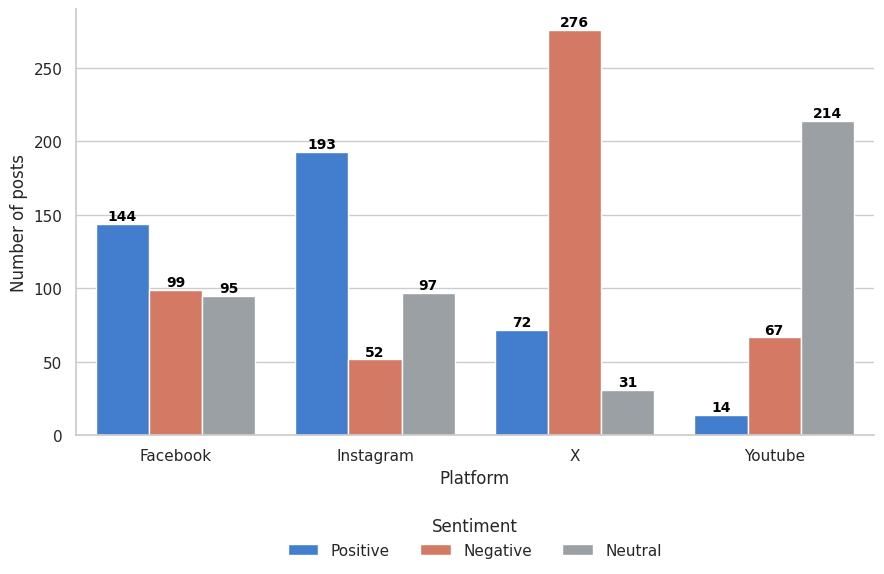

In [ ]:
# --- Aggregate counts (GT no tiene 'Indeterminate') ---
count_table = (
    df_unified
      .groupby(['platform', 'sentiment_label'])
      .size()
      .reset_index(name='count')
      .assign(sentiment_full=lambda d: d['sentiment_label'].map(label_display))
)

# --- Plot ---
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(9, 6))
ax = sns.barplot(
    data=count_table,
    x="platform", y="count", hue="sentiment_full",
    palette=palette_sent,
    hue_order=[h for h in hue_order_full if h != "Indeterminate"],  # GT no incluye indeterminados
    ci=None   # los conteos son determinísticos; SD/CI no son significativos aquí
)

# Valores encima de cada barra
for p in ax.patches:
    h = p.get_height()
    if h > 0:
        ax.annotate(f'{int(h)}',
                    (p.get_x() + p.get_width()/2., h),
                    ha='center', va='bottom',
                    fontsize=10, color='black', weight='bold')

# Estética
ax.set_xlabel("Platform", fontsize=12)
ax.set_ylabel("Number of posts", fontsize=12)

# Leyenda externa (abajo)
leg = ax.legend(
    title="Sentiment",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.16),
    ncol=3,
    frameon=False,
    fontsize=11,
    title_fontsize=12
)

sns.despine()
plt.tight_layout()
plt.subplots_adjust(bottom=0.26)  # espacio extra para la leyenda externa

save_figure(fig, "gt_sentiment_distribution_by_platform", subdir=path+"figures/", ext="pdf")
save_figure(fig, "gt_sentiment_distribution_by_platform", subdir=path+"figures/", ext="png")
plt.show()

## Beeswarm con campeones F1 en todos los modelos

[saved] /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/figures/beeswarm_models_by_sentiment.pdf
[saved] /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/figures/beeswarm_models_by_sentiment.png


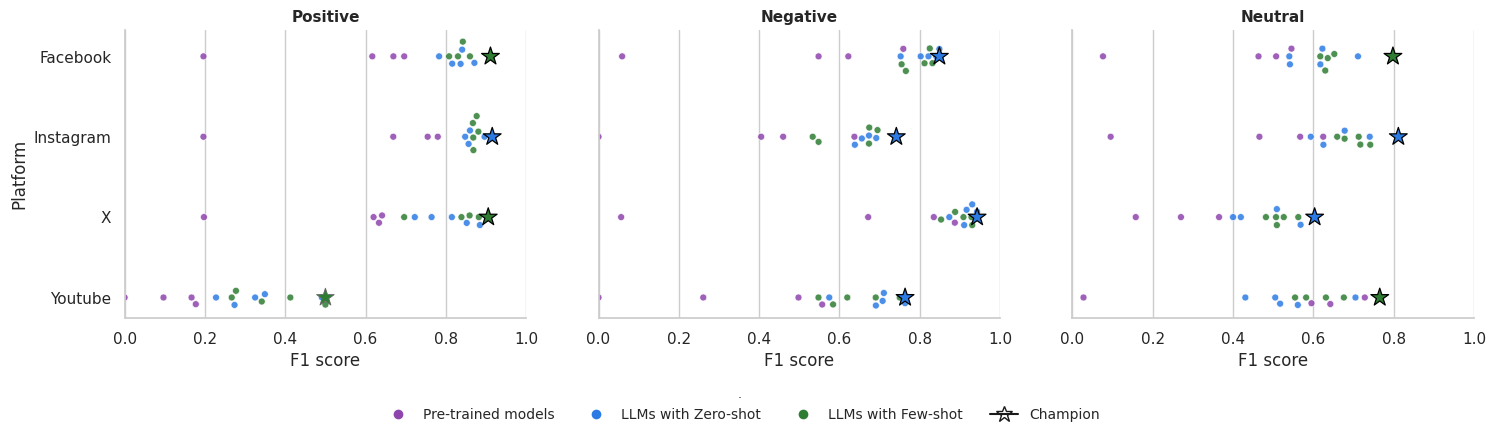

In [ ]:
SENT_ORDER = ['POS','NEG','NEU']

df_sent = df_metrics_table[df_metrics_table['sentiment'].isin(SENT_ORDER)].copy()

# Normaliza nombre de modelo (guiones, espacios) y detecta familia
def normalize_model_name(s: str) -> str:
    s = str(s).strip().replace('—','-').replace('–','-')
    return ' '.join(s.split())

def model_family(name: str) -> str:
    s = normalize_model_name(name).lower()
    if s.startswith(('dl-', 'dl ', 'dl—', 'dl —')): return 'DL'
    if s.startswith(('zero-', 'zero ', 'zero—', 'zero —')): return 'Zero'
    if s.startswith(('few-', 'few ', 'few—', 'few —')): return 'Few'
    return 'Other'

df_sent['model'] = df_sent['model'].map(normalize_model_name)
df_sent['family'] = df_sent['model'].map(model_family)
df_sent['sentiment_display'] = df_sent['sentiment'].map({"POS":"Positive","NEG":"Negative","NEU":"Neutral"})

# Campeón por plataforma×sentimiento sin filtrar soporte; marca low_support
MIN_GT_SUPPORT = 30
champ_table_plot = (
    df_sent.sort_values(['platform','sentiment','f1','recall','precision'],
                        ascending=[True, True, False, False, False])
           .groupby(['platform','sentiment'], as_index=False)
           .first()
)
champ_table_plot['low_support'] = champ_table_plot['gt_total'] < MIN_GT_SUPPORT

# Merge para flag de campeón
df_bee = df_sent.merge(
    champ_table_plot[['platform','sentiment','model','low_support']].rename(columns={'model':'champ_model'}),
    left_on=['platform','sentiment','model'],
    right_on=['platform','sentiment','champ_model'],
    how='left'
)
df_bee['is_champion'] = df_bee['champ_model'].notna()
df_bee['low_support'] = df_bee['low_support'].fillna(False)

# Paletas y rótulos de familia
family_palette = {"DL":"#8E44AD", "Zero":"#2C7BE5", "Few":"#2E7D32", "Other":"#5D6D7E"}
family_display = {"DL":"Pre-trained models","Zero":"LLMs with Zero-shot","Few":"LLMs with Few-shot","Other":"Other"}

# Plot facet
g = sns.FacetGrid(df_bee, col="sentiment_display", sharex=True, sharey=True, height=4.0, aspect=1.25)

def base_swarm(data, color, **kws):
    sns.swarmplot(
        data=data, x="f1", y="platform",
        hue="family", palette=family_palette,
        dodge=False, size=5, edgecolor="white", linewidth=0.5,
        alpha=0.85, zorder=2, legend=False
    )

def overlay_champs(data, color, **kws):
    d = data[data['is_champion']]
    if len(d):
        import numpy as np
        edge = np.where(d['low_support'], '#666666', 'black')
        lw   = np.where(d['low_support'], 0.6, 0.9)
        plt.scatter(
            d['f1'], d['platform'],
            marker='*', s=180,
            c=d['family'].map(family_palette),
            edgecolor=edge, linewidth=lw,
            zorder=10, alpha=1.0
        )

g.map_dataframe(base_swarm)
g.map_dataframe(overlay_champs)

for ax, sent in zip(g.axes.flat, ["Positive","Negative","Neutral"]):
    ax.set_title(sent, fontsize=11, weight='bold')
    ax.set_xlim(0, 1.0)
    ax.set_xlabel("F1 score")
    ax.set_ylabel("Platform")

# Leyenda inferior con rótulos solicitados
families_present = [f for f in ["DL","Zero","Few"] if f in set(df_bee['family'])]
handles = [
    plt.Line2D([0],[0], marker='o', color='w',
               markerfacecolor=family_palette[f], markeredgecolor='white',
               markersize=8, label=family_display[f])
    for f in families_present
]
handles += [plt.Line2D([0],[0], marker='*', color='k',
                       markerfacecolor='none', markeredgecolor='k',
                       markersize=12, label='Champion')]

g.fig.legend(handles=handles, loc='lower center', ncol=4, frameon=False,
             bbox_to_anchor=(0.5, -0.11), fontsize=10, title=". ", title_fontsize=9)


plt.subplots_adjust(bottom=0.18, top=0.90, wspace=0.18)

save_figure(g.fig, "beeswarm_models_by_sentiment", subdir=path+"figures/", ext="pdf")
save_figure(g.fig, "beeswarm_models_by_sentiment", subdir=path+"figures/", ext="png")

plt.show()


## Radar: GT share vs Macro-Accuracy

[saved] /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/figures/radar_gt_vs_macroacc_facebook.pdf
[saved] /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/figures/radar_gt_vs_macroacc_facebook.png


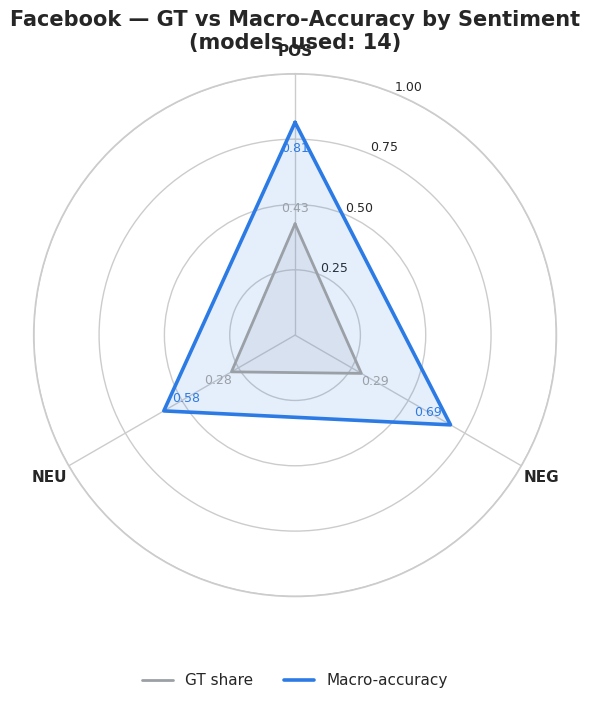

[saved] /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/figures/radar_gt_vs_macroacc_instagram.pdf
[saved] /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/figures/radar_gt_vs_macroacc_instagram.png


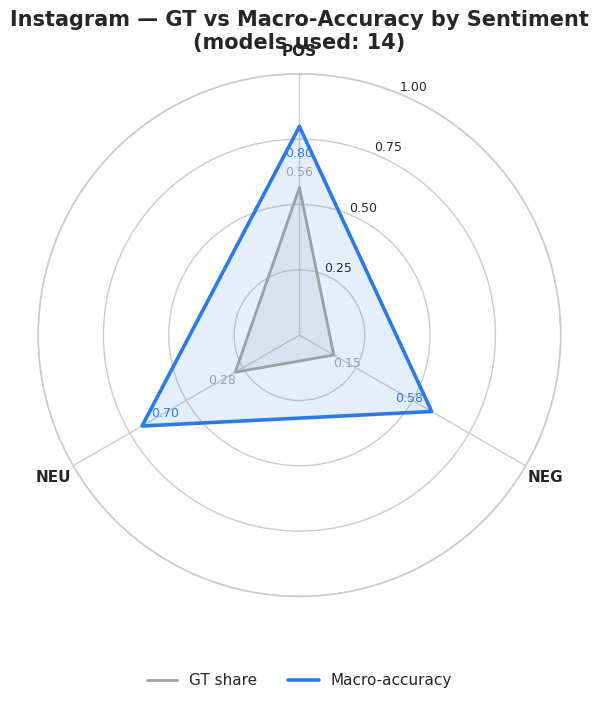

[saved] /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/figures/radar_gt_vs_macroacc_x.pdf
[saved] /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/figures/radar_gt_vs_macroacc_x.png


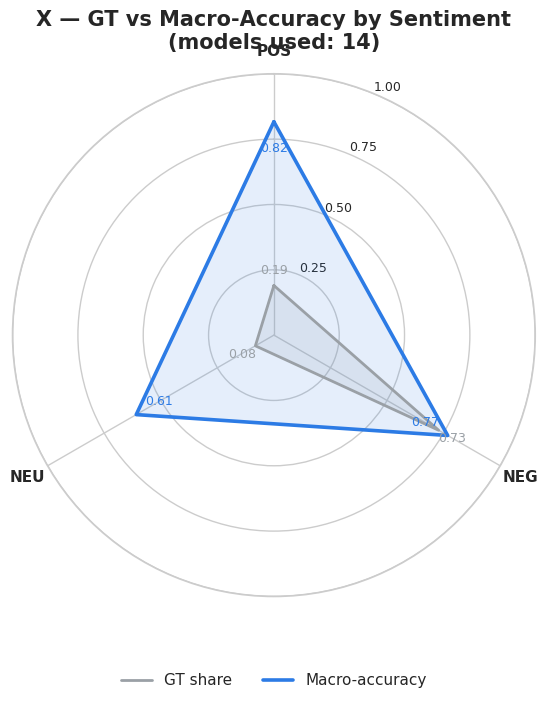

[saved] /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/figures/radar_gt_vs_macroacc_youtube.pdf
[saved] /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/figures/radar_gt_vs_macroacc_youtube.png


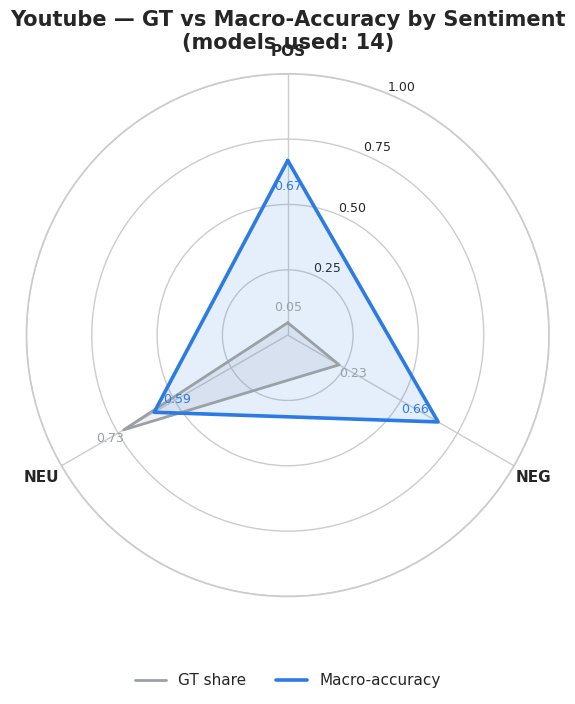

In [ ]:
# =========================
# Radar: GT share vs Macro-Accuracy (DL + LLMs), por plataforma
# =========================

# --- Configuración & constantes coherentes con el proyecto ---
SENT_ORDER = ["POS", "NEG", "NEU"]     # ejes del radar
VALID      = {"POS", "NEG", "NEU"}     # predicciones válidas (excluye INDETERMINATE)
CLR_GT     = "#9AA0A6"                 # gris (GT share)
CLR_ACC    = "#2C7BE5"                 # azul armónico (macro-accuracy)
YTICKS     = [0.25, 0.50, 0.75, 1.00]  # anillos del radar

# --- 1) Preparar lista de columnas (DL + LLMs) ---
# Reusa nuestras listas: incluye BERT-multilingual si está presente
dl_cols = [c for c in [
    'sentiment_bert_multilingual',    # <- ahora considerado
    'sentiment_beto',
    'sentiment_pysentimiento',
    'sentiment_roberta'
] if c in df_results_dl.columns]

llm_cols = [c for c in [
    'zero_gpt-3.5-turbo_sentiment','zero_gpt-4o-mini_sentiment','zero_gpt_o1-mini_sentiment',
    'zero_llama3_sentiment','zero_llama3.1_sentiment',
    'few_gpt-3.5-turbo_sentiment','few_gpt-4o-mini_sentiment','few_gpt_o1-mini_sentiment',
    'few_llama3_sentiment','few_llama3.1_sentiment'
] if c in df_results_LLMs.columns]

all_model_cols = dl_cols + llm_cols
assert len(all_model_cols) > 0, "No prediction columns found across DL/LLMs."

# --- 2) Ensamble para evaluación: GT + preds por 'text' ---
df_eval = (
    df_unified[['platform','text','sentiment_label']]
      .merge(df_results_dl[['text'] + dl_cols] if dl_cols else df_unified[['text']], on='text', how='left')
      .merge(df_results_LLMs[['text'] + llm_cols] if llm_cols else df_unified[['text']], on='text', how='left')
)

# --- 3) Agregación: GT share y Macro-Accuracy por plataforma y sentimiento ---
records = []
for plat, dfp in df_eval.groupby('platform', dropna=False):
    n_plat = len(dfp)
    for s in SENT_ORDER:
        gt_mask  = (dfp['sentiment_label'] == s)
        gt_share = gt_mask.mean() if n_plat else np.nan

        # accuracy por modelo SOLO en filas GT==s con pred válida (POS/NEG/NEU)
        accs = []
        for col in all_model_cols:
            preds = dfp.loc[gt_mask, col]
            if preds.empty:
                continue
            valid = preds.isin(VALID)
            if valid.any():
                accs.append((preds[valid] == s).mean())
        macro_acc    = np.mean(accs) if len(accs) else np.nan
        macro_acc_sd = np.std(accs, ddof=1) if len(accs) > 1 else 0.0

        records.append({
            "platform":   plat,
            "sentiment":  s,
            "gt_share":   gt_share,
            "macro_acc":  macro_acc,
            "macro_acc_sd": macro_acc_sd,
            "models_used": len(accs)
        })

df_radar = pd.DataFrame(records)
if df_radar.empty:
    raise ValueError("No records to plot — nothing aggregated.")

# Orden estable de ejes (sentimientos)
df_radar['sentiment'] = pd.Categorical(df_radar['sentiment'], categories=SENT_ORDER, ordered=True)
df_radar = df_radar.sort_values(['platform','sentiment']).reset_index(drop=True)

# --- 4) Helpers para el radar ---
def radar_angles(num_vars: int):
    """Ángulos equiespaciados + cierre de polígono."""
    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    return angles

def plot_radar_for_platform(dfp: pd.DataFrame, platform_name: str):
    """Radar para una plataforma (GT share vs Macro-accuracy)."""
    # Extrae valores en el orden de SENT_ORDER
    vals_gt  = dfp.set_index("sentiment").loc[SENT_ORDER, "gt_share"].astype(float).values
    vals_acc = dfp.set_index("sentiment").loc[SENT_ORDER, "macro_acc"].astype(float).values
    # Para dibujar, visualiza NaN como 0 (pero no los anotes)
    vals_gt_plot  = np.r_[np.nan_to_num(vals_gt,  nan=0.0),  np.nan_to_num(vals_gt[:1],  nan=0.0)]
    vals_acc_plot = np.r_[np.nan_to_num(vals_acc, nan=0.0),  np.nan_to_num(vals_acc[:1], nan=0.0)]
    angles = radar_angles(len(SENT_ORDER))

    fig = plt.figure(figsize=(7.2, 7.2))
    ax = plt.subplot(111, polar=True)

    # Layout del radar
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_ylim(0, 1.0)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(SENT_ORDER, fontsize=11, fontweight='bold')
    ax.set_yticks(YTICKS)
    ax.set_yticklabels([f"{t:.2f}" for t in YTICKS], fontsize=9)

    # Polígono GT share
    ax.plot(angles, vals_gt_plot, color=CLR_GT, linewidth=2.0, label="GT share")
    ax.fill(angles, vals_gt_plot, color=CLR_GT, alpha=0.15)

    # Polígono Macro-accuracy
    ax.plot(angles, vals_acc_plot, color=CLR_ACC, linewidth=2.6, label="Macro-accuracy")
    ax.fill(angles, vals_acc_plot, color=CLR_ACC, alpha=0.12)

    # Anotaciones en vértices (usar valores reales; omitir NaN)
    for ang, v in zip(angles[:-1], vals_gt):
        if pd.notna(v):
            ax.text(ang, min(v+0.06, 1.02), f"{v:.2f}", ha='center', va='center', fontsize=9, color=CLR_GT)
    for ang, v in zip(angles[:-1], vals_acc):
        if pd.notna(v):
            ax.text(ang, max(v-0.10, 0.02), f"{v:.2f}", ha='center', va='center', fontsize=9, color=CLR_ACC)

    # Título con número de modelos usados para el macro promedio
    used = int(dfp['models_used'].iloc[0]) if 'models_used' in dfp.columns and len(dfp) else 0
    plt.title(f"{platform_name} — GT vs Macro-Accuracy by Sentiment\n(models used: {used})",
              fontsize=15, fontweight='bold', pad=18)

    # Leyenda externa, abajo
    plt.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.12),
        ncol=2, frameon=False, fontsize=11, title_fontsize=12
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.16)
    save_figure(fig, f"radar_gt_vs_macroacc_{platform_name}", subdir=path+"figures/", ext="pdf")
    save_figure(fig, f"radar_gt_vs_macroacc_{platform_name}", subdir=path+"figures/", ext="png")
    plt.show()

# --- 5) Dibujar un radar por plataforma ---
for plat, dfp in df_radar.groupby('platform', dropna=False):
    plot_radar_for_platform(dfp, str(plat))


## Radar: Top-5 models x plataforma x metric


[saved] /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/figures/radar_top5_models_by_platform.pdf
[saved] /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/figures/radar_top5_models_by_platform.png


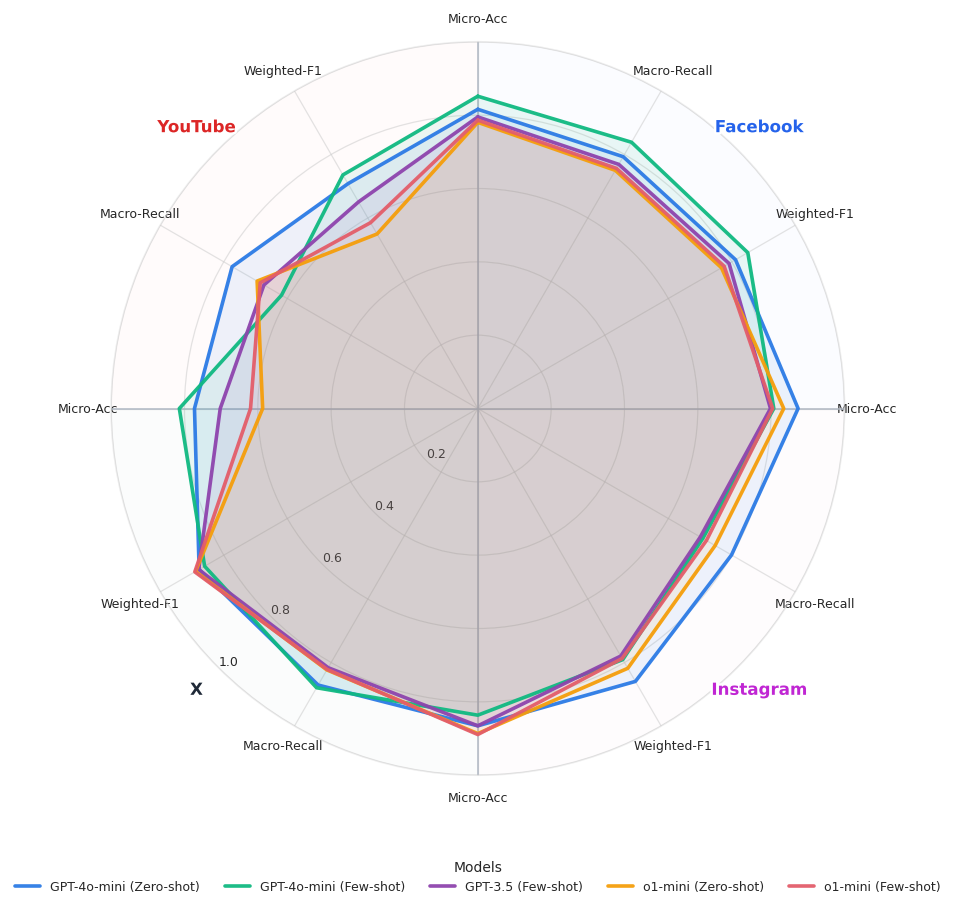

In [ ]:
# =========================
# Radar agrupado por plataforma (Top-5 modelos)
# =========================


# --- 1) Filtrar filas ALL y normalizar nombres de plataforma/modelo ---
df_all = df_metrics_table[df_metrics_table["sentiment"] == "ALL"].copy()

# Normaliza plataformas
platform_map = {"Youtube": "YouTube", "youtube": "YouTube"}
df_all["platform"] = df_all["platform"].map(lambda x: platform_map.get(x, x))

# Limpia nombre de modelo
def clean_model_name(m):
    m = str(m).replace("DL—", "DL-").replace("DL–", "DL-").replace("DL—", "DL-").replace("DL—", "DL-")
    m = m.replace("DL-", "")
    if m.startswith("Few—") or m.startswith("Few-"):
        return m.replace("Few—", "").replace("Few-", "") + " (Few-shot)"
    if m.startswith("Zero—") or m.startswith("Zero-"):
        return m.replace("Zero—", "").replace("Zero-", "") + " (Zero-shot)"
    return m

df_all["model_clean"] = df_all["model"].apply(clean_model_name)

# --- 2) Métricas y plataformas a incluir ---
metrics = [("micro_accuracy","Micro-Acc"), ("macro_recall","Macro-Recall"), ("weighted_f1","Weighted-F1")]
platforms = ["Facebook", "Instagram", "X", "YouTube"]

# --- 3) Ranking (Top-5) por promedio sobre (métrica × plataforma) ---
agg_scores = []
for model, g in df_all.groupby("model_clean"):
    vals = []
    for mkey, _mname in metrics:
        for plat in platforms:
            v = g.loc[g["platform"] == plat, mkey]
            if not v.empty:
                vals.append(float(v.iloc[0]))
    if vals:
        agg_scores.append((model, float(np.nanmean(vals))))
top5 = sorted(agg_scores, key=lambda x: x[1], reverse=True)[:5]
top5_models = [m for m, _ in top5]
if len(top5_models) == 0:
    raise ValueError("No models available for radar plot.")

# --- 4) Ejes del radar: agrupar por plataforma (cada grupo contiene las 3 métricas) ---
categories = []
group_bounds = []  # (start_idx, end_idx_exclusive, platform)
for plat in platforms:
    start = len(categories)
    for mkey, mname in metrics:
        categories.append((plat, mkey, mname))
    end = len(categories)
    group_bounds.append((start, end, plat))

N = len(categories)
angles = np.linspace(0, 2*np.pi, N, endpoint=False)
angles_full = np.r_[angles, angles[0]]



# Paleta para modelos (se mantiene)
model_colors = [
    "#2C7BE5",  # azul vibrante
    "#10B981",  # verde esmeralda
    "#8E44AD",  # púrpura
    "#F59E0B",  # ámbar
    "#E35D6A",  # rojo suave
    "#7C3AED",  # morado intenso (backup)
    "#059669"   # verde profundo (backup)
]

# Colores de fondo y del label por plataforma (más distintivos)
platform_bg = {
    "Facebook":  ("#E0ECFF", "#2563EB"),  # (relleno suave, label azul)
    "Instagram": ("#FCE7F3", "#C026D3"),  # magenta-violeta
    "X":         ("#E5E7EB", "#1F2937"),  # gris + grafito
    "YouTube":   ("#FFE4E6", "#DC2626"),  # rosado claro + rojo
}

# Construcción de ejes (si ya definiste categories, angles, group_bounds arriba, lo reutiliza)
N = len(categories)
angles = np.linspace(0, 2*np.pi, N, endpoint=False)
angles_full = np.r_[angles, angles[0]]

fig=plt.figure(figsize=(9.8, 9.8))
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_ylim(0, 1.0)

# Ticks radiales y de ángulo
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2","0.4","0.6","0.8","1.0"], fontsize=9)
# Mueve las etiquetas radiales a ~225° para evitar que el "1.0" choque con Facebook/Macro-Recall
ax.set_rlabel_position(225)

ax.set_xticks(angles)
ax.set_xticklabels([mname for (_plat, _mkey, mname) in categories], fontsize=9)

# Grid y borde
for spine in ax.spines.values():
    spine.set_alpha(0.35)
ax.grid(True, linewidth=0.9, alpha=0.55)

# Fondos y separadores por grupo + label de plataforma con trazo blanco para legibilidad
width_unit = 2*np.pi / N
for (start, end, plat) in group_bounds:
    theta0 = angles[start]
    width  = (end - start) * width_unit
    fill_col, lbl_col = platform_bg.get(plat, ("#EEF2F7", "#374151"))

    # Wedge de fondo (muy suave)
    ax.bar(theta0, 1.0, width=width, bottom=0.0, color=fill_col, alpha=0.12,
           edgecolor='none', align='edge', zorder=0)

    # Separador del grupo
    ax.plot([theta0, theta0], [0, 1.03], color="#B0B8C3", linewidth=1.1, zorder=1)

    # Label de plataforma en el centro del grupo, con trazo blanco (mejor contraste)
    mid = theta0 + width/2.0
    txt = ax.text(mid, 1.085, plat, ha='center', va='center',
                  fontsize=12, fontweight='bold', color=lbl_col, zorder=3)
    txt.set_path_effects([pe.withStroke(linewidth=3.5, foreground="white")])

# Traza de los Top-5 modelos
for i, model in enumerate(top5_models):
    g = df_all[df_all["model_clean"] == model]
    values = []
    for plat, mkey, _mname in categories:
        v = g.loc[g["platform"] == plat, mkey]
        values.append(float(v.iloc[0]) if not v.empty and np.isfinite(v.iloc[0]) else 0.0)
    values = np.array(values, dtype=float)
    values_full = np.r_[values, values[0]]

    col = model_colors[i % len(model_colors)]
    ax.plot(angles_full, values_full, linewidth=2.6, color=col, label=model, alpha=0.95, zorder=5)
    ax.fill(angles_full, values_full, color=col, alpha=0.08, zorder=2)

# --- Título y leyenda inferior (horizontal) ---
ax.set_title(" ",
             fontsize=15, fontweight="bold", pad=12)

# nº de columnas en la leyenda (ajuste automático)
ncol = max(3, min(len(top5_models), 5))

# Usa los handles/labels ya generados por las líneas del radar
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles, labels,
                loc="upper center",
                bbox_to_anchor=(0.5, -0.10),   # fuera del eje, abajo
                ncol=ncol,
                frameon=False,
                fontsize=9,
                title="Models", title_fontsize=10)

plt.tight_layout()
plt.subplots_adjust(bottom=0.20)  # deja espacio para la leyenda
save_figure(fig, f"radar_top5_models_by_platform", subdir=path+"figures/", ext="pdf")
save_figure(fig, f"radar_top5_models_by_platform", subdir=path+"figures/", ext="png")
plt.show()

##  Lollipop: DL mean vs Top-3 LLMs

[saved] /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/figures/lollipop_dl_vs_top3_llms.pdf
[saved] /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/figures/lollipop_dl_vs_top3_llms.png


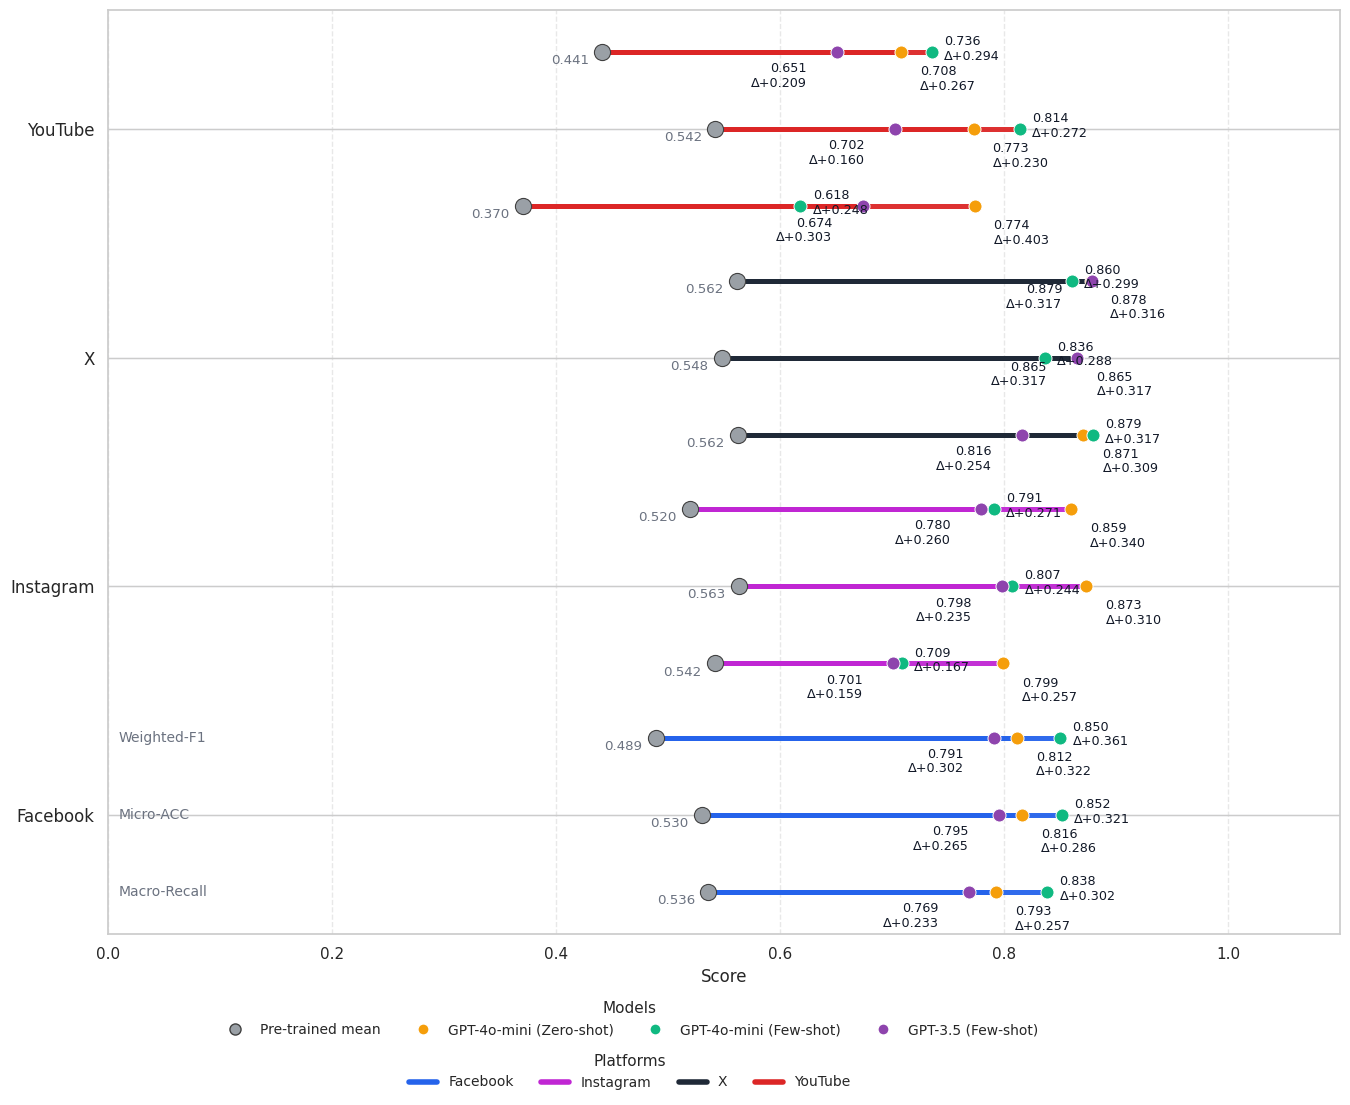

In [ ]:
# Lollipop: Pre-trained mean vs Top-3 LLMs — per Platform & Metric

# Se trabaja anti-colisión robusta entre regiones de modelos

# -------------------------------
# 1) Filtrar filas 'ALL' y normalizar plataformas
# -------------------------------
df_all = df_metrics_table[df_metrics_table["sentiment"] == "ALL"].copy()
platform_map = {"Youtube": "YouTube", "youtube": "YouTube"}
df_all["platform"] = df_all["platform"].map(lambda x: platform_map.get(x, x))

# -------------------------------
# 2) Normalizar nombres y detectar familia
# -------------------------------
def normalize_model_name(s: str) -> str:
    return str(s).replace('—','-').replace('–','-').strip()

def model_family(name: str) -> str:
    s = normalize_model_name(name).lower()
    if s.startswith(('dl-', 'dl ')):       return 'DL'
    if s.startswith(('zero-', 'zero ')):   return 'Zero'
    if s.startswith(('few-', 'few ')):     return 'Few'
    return 'Other'

df_all["model_norm"] = df_all["model"].map(normalize_model_name)
df_all["family"]     = df_all["model"].map(model_family)

# -------------------------------
# 3) Elegir Top-3 LLMs por Weighted-F1 medio (global)
# -------------------------------
llm_means = (df_all[df_all["family"].isin(["Zero","Few"])]
             .groupby("model_norm", as_index=False)["weighted_f1"]
             .mean()
             .sort_values("weighted_f1", ascending=False))

top3_models = llm_means["model_norm"].head(3).tolist()
if not top3_models:
    raise ValueError("No LLM models available to pick Top-3.")

# -------------------------------
# 4) Configuración general
# -------------------------------
platforms = ["Facebook", "Instagram", "X", "YouTube"]
metrics   = [("weighted_f1","Weighted-F1"),
             ("micro_accuracy","Micro-ACC"),
             ("macro_recall","Macro-Recall")]

# Espaciado vertical
PLAT_GAP   = 4.0     # separación entre plataformas (↑ para más aire)
LANE_SHIFT = 1.35    # separación entre los 3 carriles por plataforma
y_base = np.arange(len(platforms)) * PLAT_GAP
lane_offsets = {"weighted_f1": +LANE_SHIFT, "micro_accuracy": 0.0, "macro_recall": -LANE_SHIFT}

# Etiquetas: desplazamientos base (y) para los 3 LLMs (3º más "atrás")
TEXT_DY_BASE = {0: -0.47, 1: 0.054, 2: -0.42}

# Etiquetas: desplazamientos base (x)
#   3er LLM a la IZQUIERDA; los otros a la DERECHA (ajustable por colisiones de borde)
TEXT_DX_BASE = {0: +0.017, 1: +0.011, 2: -0.027}

# Anti-colisión
X_PAD_RIGHT   = 0.10     # margen extra a la derecha para textos
MIN_X_GAP     = 0.020    # si dos puntos están más cerca que esto en x → separamos en y
MIN_Y_SEP     = 0.18     # separación vertical mínima entre etiquetas multi-línea
X_CLIP_RIGHT  = 0.985    # si x>esto, forzamos etiqueta a la izquierda
X_CLIP_LEFT   = 0.015    # si x<esto, forzamos etiqueta a la derecha
MULTILINE_LABEL = True   # valor y Δ en dos líneas

# Colores: palitos por plataforma (consistentes con radar anterior)
platform_line_col = {
    "Facebook":  "#2563EB",  # azul
    "Instagram": "#C026D3",  # magenta-violeta
    "X":         "#1F2937",  # grafito
    "YouTube":   "#DC2626",  # rojo
}
# Colores: puntos por LLM (override ámbar para Zero–GPT-4o-mini)
base_llm_colors = ["#2C7BE5", "#10B981", "#8E44AD"]  # azul, verde, púrpura
model_color = {}
for j, m in enumerate(top3_models):
    model_color[m] = base_llm_colors[j % len(base_llm_colors)]
for m in list(model_color.keys()):
    if normalize_model_name(m).lower().startswith("zero-gpt-4o-mini"):
        model_color[m] = "#F59E0B"  # ámbar

# Baseline (DL promedio)
dl_color, dl_edge = "#9AA0A6", "#404040"

# -------------------------------
# 5) Datos de referencia (DL) y valores por LLM
# -------------------------------
dl_ref = (df_all[df_all["family"]=="DL"]
          .groupby("platform")[["weighted_f1","micro_accuracy","macro_recall"]]
          .mean()
          .reindex(platforms))

llm_vals = {}
for m in top3_models:
    g = df_all[df_all["model_norm"]==m]
    pvt = (g.pivot_table(index="platform",
                         values=["weighted_f1","micro_accuracy","macro_recall"],
                         aggfunc="mean")
             .reindex(platforms))
    llm_vals[m] = pvt

# -------------------------------
# 6) Helpers
# -------------------------------
def fmt_label(x, ref):
    if MULTILINE_LABEL:
        return f"{x:.3f}\nΔ{(x-ref):+0.3f}" if not np.isnan(ref) else f"{x:.3f}"
    return f"{x:.3f} (Δ{(x-ref):+0.3f})" if not np.isnan(ref) else f"{x:.3f}"

def resolve_lane_offsets(xs, base_dys, min_x_gap=MIN_X_GAP, min_y_sep=MIN_Y_SEP, rounds=6):
    """Ajusta dy de 3 etiquetas con varias pasadas para evitar choques 1↔2, 2↔3 y 1↔3."""
    idxs = [i for i, x in enumerate(xs) if not np.isnan(x)]
    if not idxs:
        return {}
    dy = {i: base_dys.get(i, 0.0) for i in idxs}
    order = sorted(idxs, key=lambda i: xs[i])  # izq→der

    # Pasadas hacia adelante
    for _ in range(rounds):
        moved = False
        for a, b in zip(order, order[1:]):
            if abs(xs[b] - xs[a]) < min_x_gap and abs(dy[b] - dy[a]) < min_y_sep:
                dir_b = 1 if base_dys.get(b, 0.0) >= base_dys.get(a, 0.0) else -1
                dy[b] = dy[a] + dir_b * min_y_sep
                moved = True
        if not moved:
            break
    # Pasadas hacia atrás
    for _ in range(rounds):
        moved = False
        for a, b in zip(reversed(order), reversed(order[:-1])):
            if abs(xs[b] - xs[a]) < min_x_gap and abs(dy[b] - dy[a]) < min_y_sep:
                dir_b = -1 if base_dys.get(b, 0.0) <= base_dys.get(a, 0.0) else 1
                dy[b] = dy[a] + dir_b * min_y_sep
                moved = True
        if not moved:
            break
    return dy

# -------------------------------
# 7) Plot
# -------------------------------
fig, ax = plt.subplots(figsize=(14.5, 10.5))  # más alto y ancho
ax.set_yticks(y_base)
ax.set_yticklabels(platforms, fontsize=12)
ax.set_xlim(0.0, 1.0 + X_PAD_RIGHT)
ax.grid(axis='x', linestyle='--', alpha=0.45)
ax.set_xlabel("Score", fontsize=12)

# Separadores horizontales por plataforma
for y0 in y_base:
    ax.axhline(y0, color="#e5e7eb", linewidth=0.9, zorder=0)

# Etiquetas de carril en la primera plataforma
lane_labels = {"weighted_f1":"Weighted-F1", "micro_accuracy":"Micro-ACC", "macro_recall":"Macro-Recall"}
for mkey, short_lbl in lane_labels.items():
    ax.text(0.01, y_base[0] + lane_offsets[mkey],
            short_lbl, ha='left', va='center', fontsize=10, color="#6B7280")

# Dibujar por plataforma y métrica
for i, plat in enumerate(platforms):
    line_col = platform_line_col.get(plat, "#6B7280")
    for mkey, _mname in metrics:
        y = y_base[i] + lane_offsets[mkey]
        ref = float(dl_ref.loc[plat, mkey]) if plat in dl_ref.index and mkey in dl_ref.columns else np.nan

        # Baseline (DL mean): punto + etiqueta abajo/izquierda
        if not np.isnan(ref):
            ax.scatter([ref], [y], s=135, color=dl_color, edgecolor=dl_edge, linewidth=0.8, zorder=4)
            ax.text(ref - 0.012, y - 0.15, f"{ref:.3f}", fontsize=9.6,
                    color="#6B7280", va='center', ha='right')

        # xs de los 3 LLMs para este carril
        xs_lane = []
        for m in top3_models:
            pvt = llm_vals[m]
            xj = float(pvt.loc[plat, mkey]) if plat in pvt.index and mkey in pvt.columns else np.nan
            xs_lane.append(xj)

        # Desplazamientos anti-colisión (en y)
        dy_ok = resolve_lane_offsets(xs_lane, TEXT_DY_BASE)

        # Lollipops + puntos + etiquetas
        for j, m in enumerate(top3_models):
            x1 = xs_lane[j]
            if np.isnan(x1) or np.isnan(ref):
                continue

            # Palito (color de plataforma)
            ax.plot([min(ref, x1), max(ref, x1)], [y, y],
                    color=line_col, linewidth=3.6, alpha=0.95,
                    solid_capstyle='round', zorder=2)

            # Punto del LLM
            ax.scatter([x1], [y], s=88, color=model_color[m],
                       edgecolor="white", linewidth=0.7, zorder=5)

            # Lado de la etiqueta: 3º LLM a la izquierda; los otros a la derecha
            dx = TEXT_DX_BASE.get(j, 0.012)
            dx = -abs(dx) if j == 2 else abs(dx)

            # Evitar cortes con los bordes
            if x1 > X_CLIP_RIGHT and dx > 0:
                dx = -dx
            if x1 < X_CLIP_LEFT and dx < 0:
                dx = abs(dx)

            x_text = x1 + dx
            ha = 'left' if dx >= 0 else 'right'

            ax.text(x_text, y + dy_ok.get(j, 0.0), fmt_label(x1, ref),
                    fontsize=9.2, color="#111827",
                    va="center", ha=ha, linespacing=1.15, zorder=7)

# Título
# ax.set_title("Pre-trained mean vs Top-3 LLMs — per Platform and Metric",
#              fontsize=17, fontweight='bold', pad=14)

# Leyendas horizontales
handles_models = [
    Line2D([0],[0], marker='o', color='w',
           markerfacecolor=dl_color, markeredgecolor=dl_edge,
           markersize=8, label='Pre-trained mean')
]
for m in top3_models:
    pretty = m
    low = pretty.lower()
    if low.startswith("zero-"):
        pretty = pretty.replace("Zero-","") + " (Zero-shot)"
    elif low.startswith("few-"):
        pretty = pretty.replace("Few-","") + " (Few-shot)"
    handles_models.append(
        Line2D([0],[0], marker='o', color='w',
               markerfacecolor=model_color[m], markeredgecolor='white',
               markersize=8, label=pretty)
    )

handles_plat = [Line2D([0],[0], color=platform_line_col[p], linewidth=4, label=p)
                for p in platforms]

fig.legend(handles=handles_models, loc="lower center",
           bbox_to_anchor=(0.5, -0.02), ncol=len(handles_models),
           frameon=False, fontsize=10, title="Models", title_fontsize=11)

fig.legend(handles=handles_plat, loc="lower center",
           bbox_to_anchor=(0.5, -0.07), ncol=len(handles_plat),
           frameon=False, fontsize=10, title="Platforms", title_fontsize=11)

plt.subplots_adjust(bottom=0.09, top=0.97, left=0.14, right=0.99)

save_figure(fig, "lollipop_dl_vs_top3_llms", subdir=path+"figures/", ext="pdf")
save_figure(fig, "lollipop_dl_vs_top3_llms", subdir=path+"figures/", ext="png")

plt.show()
